In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

### Data Preparation ###

In [3]:
data = pd.read_csv('data.csv')
data = data[["Make",
"Model",
"Year",
"Engine HP",
"Engine Cylinders",
"Transmission Type",
"Vehicle Style",
"highway MPG",
"city mpg","MSRP"]]

In [4]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

In [5]:
data.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [6]:
data.engine_hp.fillna(0,inplace=True)
data.engine_cylinders.fillna(0,inplace=True)

In [7]:
data.rename(columns={'msrp':'price'},inplace=True)

In [8]:
mean_price = data['price'].mean()
data['above_average'] = np.where(data['price'] > mean_price,1,0)

In [9]:
data_backup = data.copy()
data.drop('price',axis=1,inplace=True)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [10]:
from sklearn.model_selection import train_test_split
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.2, random_state=1)

### Question 1: ROC AUC feature importance

In [11]:
numerical_columns = list(X_train.select_dtypes(include=[np.number]).columns)
categorical_columns = list(X_train.select_dtypes(exclude=[np.number]))

In [12]:
from operator import itemgetter
auc_list = []
for num in numerical_columns:
    auc = roc_auc_score(y_train, X_train[num])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[num])
    auc_list.append((num,auc))
max(auc_list, key = itemgetter(1))

('engine_hp', 0.9162324220917971)

engine_hp has the highest AUC

### Question 2: Training the model

In [13]:
train_dicts = X_train[list(X_train.columns)].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train_1 = dv.fit_transform(train_dicts)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_1, y_train)
val_dicts = X_val[list(X_val.columns)].to_dict(orient='records')
X_val_1 = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val_1)[:, 1]
round(roc_auc_score(y_val, y_pred),3)

0.978

AUC of this model on the validation dataset is ~0.979

In [14]:
def confusion_matrix(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

df_scores = confusion_matrix(y_val, y_pred)
df_scores.head()

,threshold,tp,fp,fn,tn
0,0.00,527,1380,0,0
1,0.01,525,656,2,724
2,0.02,524,525,3,855
3,0.03,524,471,3,909
4,0.04,523,426,4,954


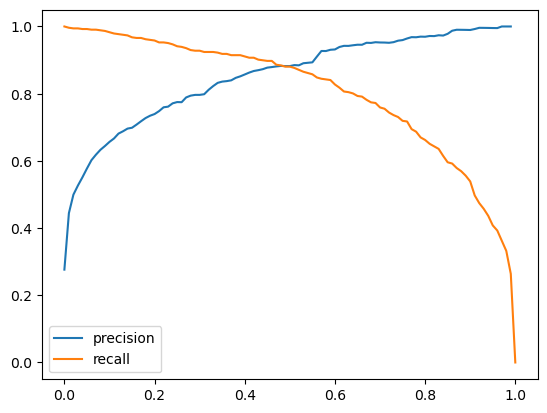

In [15]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')
plt.legend()
plt.show()

In [16]:
df_scores[abs(df_scores.p - df_scores.r) < 0.01]

,threshold,tp,fp,fn,tn,p,r
47,0.47,467,63,60,1317,0.881132,0.886148
48,0.48,466,62,61,1318,0.882576,0.884250
49,0.49,464,62,63,1318,0.882129,0.880455
50,0.50,464,62,63,1318,0.882129,0.880455
51,0.51,462,60,65,1320,0.885057,0.876660


At threshold 0.48 precision and recall curves intersect

### Question 4: F1 score

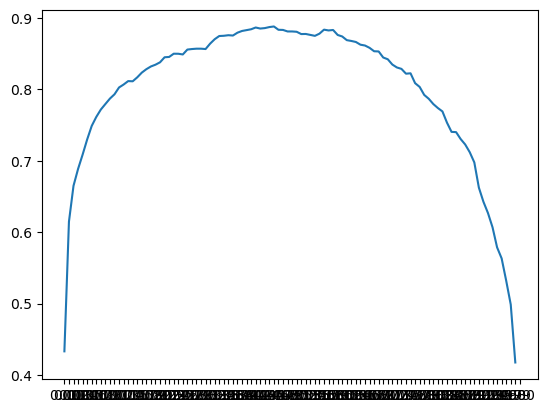

In [17]:
df_scores['f1'] = (2 * df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 101))
plt.show()

In [18]:
df_scores[df_scores['f1']==df_scores['f1'].max()].threshold

46    0.46
Name: threshold, dtype: float64

In [19]:
df_scores[df_scores['threshold']==0.32].f1

32    0.864241
Name: f1, dtype: float64

In [20]:
df_scores[df_scores['threshold']==0.46].f1

46    0.888263
Name: f1, dtype: float64

In [21]:
df_scores[df_scores['threshold']==0.52].f1

52    0.877629
Name: f1, dtype: float64

In [22]:
df_scores[df_scores['threshold']==0.12].f1

12    0.802806
Name: f1, dtype: float64

In [23]:
df_scores[df_scores['threshold']==0.72].f1

72    0.834931
Name: f1, dtype: float64

f1 score coming maximum at 0.46 and maximal at 0.52

### Question 5: 5-Fold CV

In [24]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[list(df_train.columns)].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C,max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[list(df.columns)].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [25]:
df_full_train = X_full_train.copy().reset_index(drop=True)

In [26]:
y_full_train.reset_index(drop=True,inplace=True)

In [27]:
df_full_train['above_average'] = y_full_train

In [28]:
df_full_train['above_average']

0       1
1       0
2       0
3       1
4       0
       ..
9526    1
9527    1
9528    0
9529    0
9530    0
Name: above_average, Length: 9531, dtype: int32

In [29]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
#df_full_train = pd.concat([X_full_train,y_full_train],axis=0)
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.above_average
    y_val = df_val.above_average
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(round(np.mean(scores),3), round(np.std(scores),3))

1.0 0.0


Standard Deviation is coming close to option 0.003

### Question 6: Hyperparemeter Tuning

In [30]:
for C in [0.01, 0.1, 0.5, 10]:
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    #df_full_train = pd.concat([X_full_train,y_full_train],axis=0)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.above_average
        y_val = df_val.above_average
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(f'The score for C value {C}')
    print(round(np.mean(scores),3), round(np.std(scores),3))

The score for C value 0.01
0.997 0.001
The score for C value 0.1
1.0 0.0
The score for C value 0.5
1.0 0.0
The score for C value 10
1.0 0.0


The value of C with the best mean score is 0.1